In [4]:
import os
import numpy as np
import random
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
from dataset import dataset
from neural_network import neural_net
from additional_functions import process_all
from additional_functions import save_arrays_to_csv
from additional_functions import load_arrays_from_csv
from additional_functions import make_plots_2

# Neural Network Instantiation

In [5]:
abalone_data, cancer_data, fire_data, glass_data, machine_data, soybean_data = process_all('carlthedog3', True)

In [6]:
# Classification Sets
cancer_net_0 = neural_net(cancer_data, "classification", hidden_layer_count=0, epochs=10,momentum=.5,learning_rate=.01,batch_size=16)
cancer_net_1 = neural_net(cancer_data, "classification", hidden_layer_count=1, network_shape=[9,1,2],epochs=50,momentum=.7,learning_rate=.1,batch_size=16)
cancer_net_2 = neural_net(cancer_data, "classification", hidden_layer_count=2, network_shape=[9,1,5,2],epochs=50,momentum=.9,learning_rate=.01,batch_size=16)

glass_net_0 = neural_net(glass_data, "classification", hidden_layer_count=0, epochs=100,momentum=.5,learning_rate=.001,batch_size=16)
glass_net_1 = neural_net(glass_data, "classification", hidden_layer_count=1, network_shape=[9,1,6],epochs=500,momentum=.95,learning_rate=.01,batch_size=32)
glass_net_2 = neural_net(glass_data, "classification", hidden_layer_count=2, network_shape=[9,1,9,6],epochs=500,momentum=.95,learning_rate=.01,batch_size=32)

soybean_net_0 = neural_net(soybean_data, "classification", hidden_layer_count=0, epochs=10,momentum=.99,learning_rate=.01,batch_size=16)
soybean_net_1 = neural_net(soybean_data, "classification", hidden_layer_count=1, network_shape=[35,1,4],epochs=500,momentum=.99,learning_rate=.01,batch_size=16)
soybean_net_2 = neural_net(soybean_data, "classification", hidden_layer_count=2, network_shape=[35,1,9,4],epochs=500,momentum=.95,learning_rate=.1,batch_size=256)


# Regression Sets
abalone_net_0 = neural_net(abalone_data, "regression", hidden_layer_count=0, epochs=200,momentum=.9,learning_rate=.01,batch_size=32)
abalone_net_1 = neural_net(abalone_data, "regression", hidden_layer_count=1, network_shape=[8,1,1],epochs=500,momentum=.95,learning_rate=.01,batch_size=16)
abalone_net_2 = neural_net(abalone_data, "regression", hidden_layer_count=2, network_shape=[8,1,9,1],epochs=500,momentum=.99,learning_rate=.001,batch_size=16)

fire_net_0 = neural_net(fire_data, "regression", hidden_layer_count=0, epochs=200,momentum=.9,learning_rate=.01,batch_size=16)
fire_net_1 = neural_net(fire_data, "regression", hidden_layer_count=1, network_shape=[12,1,1],epochs=200,momentum=.95,learning_rate=.01,batch_size=16)
fire_net_2 = neural_net(fire_data, "regression", hidden_layer_count=2, network_shape=[12,1,1,1],epochs=500,momentum=.95,learning_rate=.001,batch_size=16)

machine_net_0 = neural_net(machine_data, "regression", hidden_layer_count=0, epochs=500,momentum=.95,learning_rate=.01,batch_size=16)
machine_net_1 = neural_net(machine_data, "regression", hidden_layer_count=1, network_shape=[9,1,1],epochs=500,momentum=.99,learning_rate=.01,batch_size=16)
machine_net_2 = neural_net(machine_data, "regression", hidden_layer_count=2, network_shape=[9,1,7,1],epochs=500,momentum=.99,learning_rate=.01,batch_size=16)

# Abalone Tuning + Final Scores

In [7]:
#abalone_net_0_parameters = abalone_net_0.tune()
abalone_0_score = abalone_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_0_score)}")

KeyboardInterrupt: 

In [ ]:
#abalone_net_1_parameters = abalone_net_1.tune()
abalone_1_score = abalone_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_1_score)}")

Average Performance: 0.006559091413981334


In [ ]:
#abalone_net_2_parameters = abalone_net_2.tune()
abalone_2_score = abalone_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(abalone_2_score)}")

Average Performance: 0.006931437623464018


# Fire Tuning + Final Scores

In [ ]:
#fire_net_0_parameters = fire_net_0.tune()
fire_0_score = fire_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_0_score)}")

Average Performance: 0.005721274142668384


In [ ]:
#fire_net_1_parameters = fire_net_1.tune()
fire_1_score = fire_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_1_score)}")

Average Performance: 0.0037049092062057245


In [ ]:
#fire_net_2_parameters = fire_net_2.tune()
fire_2_score = fire_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(fire_2_score)}")

Average Performance: 0.0037254296840037344


# Machine Tuning + Final Scores

In [ ]:
#machine_net_0_parameters = machine_net_0.tune()
machine_0_score = machine_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_0_score)}")

Average Performance: 0.0010733058271575635


In [ ]:
#machine_net_1_parameters = machine_net_1.tune()
machine_1_score = machine_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_1_score)}")

Average Performance: 0.006593045274298735


In [ ]:
#machine_net_2_parameters = machine_net_2.tune()
machine_2_score = machine_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(machine_2_score)}")

Average Performance: 0.004282514017486736


# Cancer Tuning + Final Scores

In [ ]:
#cancer_net_0_parameters = cancer_net_0.tune()
cancer_0_score = cancer_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_0_score)}")

Average Performance: 0.42910906298003065


In [ ]:
#cancer_net_1_parameters = cancer_net_1.tune()
cancer_1_score = cancer_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_1_score)}")

Average Performance: 0.9650281618023552


In [ ]:
#cancer_net_2_parameters = cancer_net_2.tune()
cancer_2_score = cancer_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(cancer_2_score)}")

Average Performance: 0.9682027649769583


# Glass Tuning + Final Scores

In [ ]:
#glass_net_0_parameters = glass_net_0.tune()
glass_0_score = glass_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_0_score)}")

Average Performance: 0.010263157894736842


In [ ]:
#glass_net_1_parameters = glass_net_1.tune()
glass_1_score = glass_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_1_score)}")

Average Performance: 0.58


In [ ]:
#glass_net_2_parameters = glass_net_2.tune()
glass_2_score = glass_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(glass_2_score)}")

Average Performance: 0.59


# Soybean Tuning + Final Scores

In [ ]:
#soybean_net_0_parameters = soybean_net_0.tune()
soybean_0_score = soybean_net_0.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_0_score)}")

Average Performance: 0.125


In [ ]:
#soybean_net_1_parameters = soybean_net_1.tune()
soybean_1_score = soybean_net_1.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_1_score)}")

Average Performance: 0.765


In [ ]:
#soybean_net_2_parameters = soybean_net_2.tune()
soybean_2_score = soybean_net_2.train_test(tuning_flag=False)
print(f"Average Performance: {np.mean(soybean_2_score)}")

Average Performance: 0.8800000000000001


# Plotting Metrics

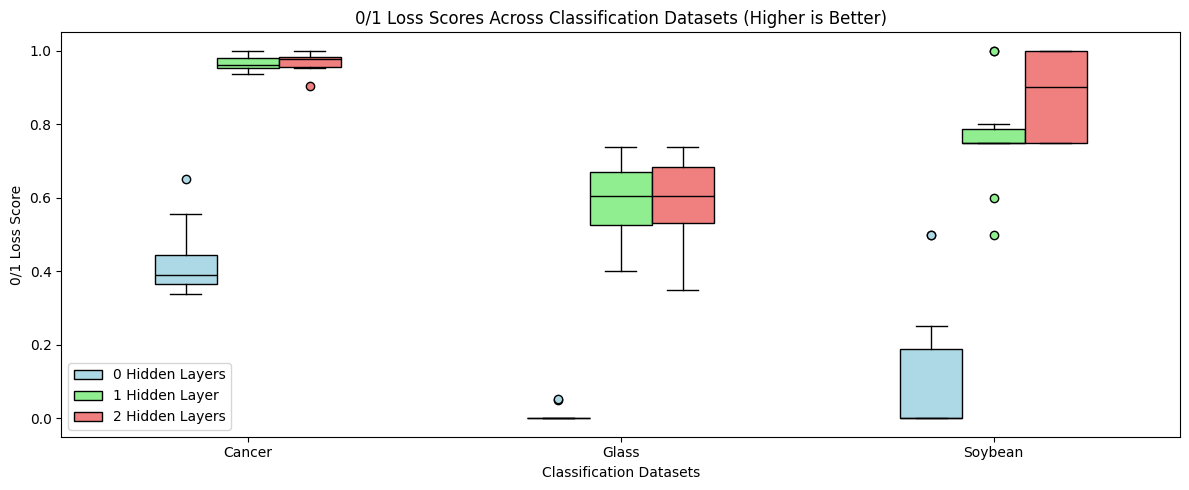

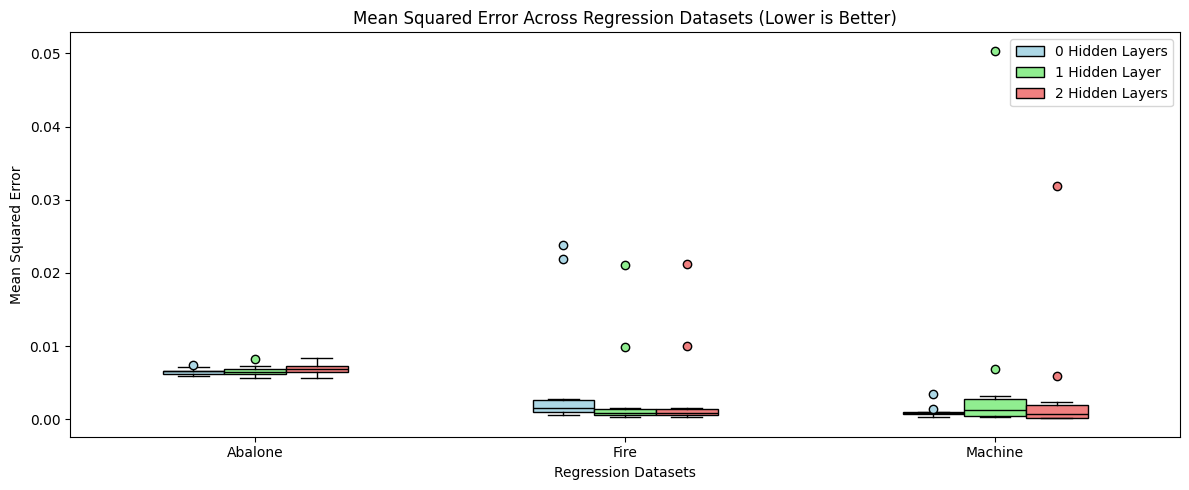

In [ ]:
#classification_arrays = [cancer_0_score,cancer_1_score,cancer_2_score,
#                         glass_0_score,glass_1_score,glass_2_score,
#                         soybean_0_score,soybean_1_score,soybean_2_score]
#regression_arrays = [abalone_0_score,abalone_1_score,abalone_2_score,
#                     fire_0_score,fire_1_score,fire_2_score,
#                     machine_0_score,machine_1_score,machine_2_score]
#arrays_to_save = []
#arrays_to_save.extend(classification_arrays)
#arrays_to_save.extend(regression_arrays)
#print(arrays_to_save)
#save_arrays_to_csv(arrays_to_save, 'results.csv')
loaded_arrays = load_arrays_from_csv('results.csv')
#loaded_arrays[1] = cancer_1_score
classification_arrays = loaded_arrays[:9]
regression_arrays = loaded_arrays[9:]
#loaded_arrays = classification_arrays
#loaded_arrays.extend(regression_arrays)
classification_dataset_names = ['Cancer', 'Glass', 'Soybean']
regression_dataset_names = ['Abalone', 'Fire', 'Machine']

make_plots_2(loaded_arrays, classification_dataset_names, regression_dataset_names, (12, 5), 0, '/home/carlthedog3/CSCI_447/Project_3/Code/Figures/')